In [7]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors


In [9]:
# 2. Load data
file_path = "/Users/gulizkonca/Downloads/Mall_Customers.xlsx"
df = pd.read_excel(file_path)
print(df.head(), "\n")
print(df.info(), "\n")


   CustomerID Gender  Age   Education  Marital Status  Annual Income (k$)  \
0           1      M   19  High School        Married                  15   
1           2      M   21     Graduate         Single                  15   
2           3      F   20     Graduate        Married                  16   
3           4      F   23  High School        Unknown                  16   
4           5      F   31   Uneducated        Married                  17   

   Spending Score (1-100)  
0                      39  
1                      81  
2                       6  
3                      77  
4                      40   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3 

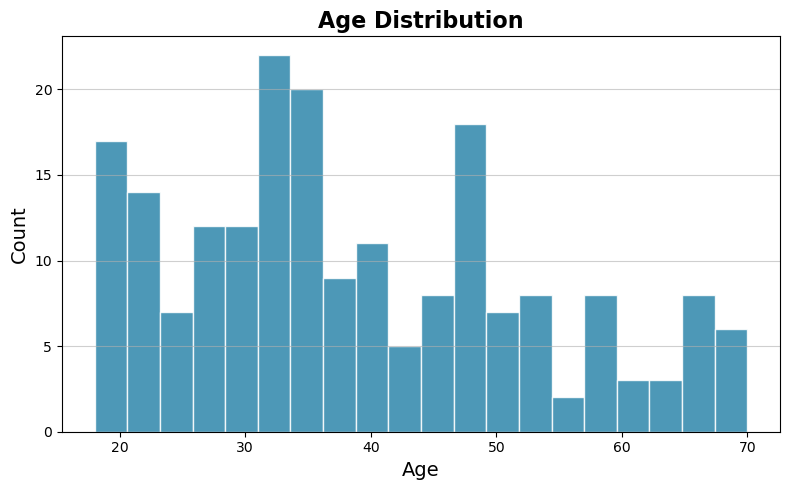

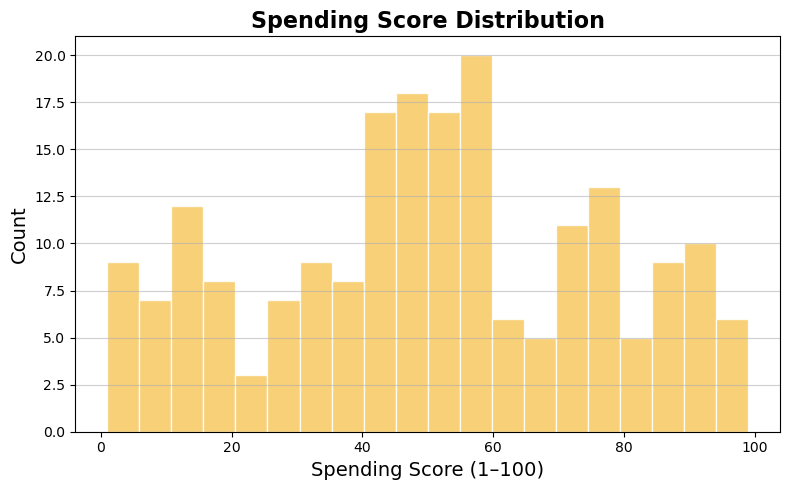

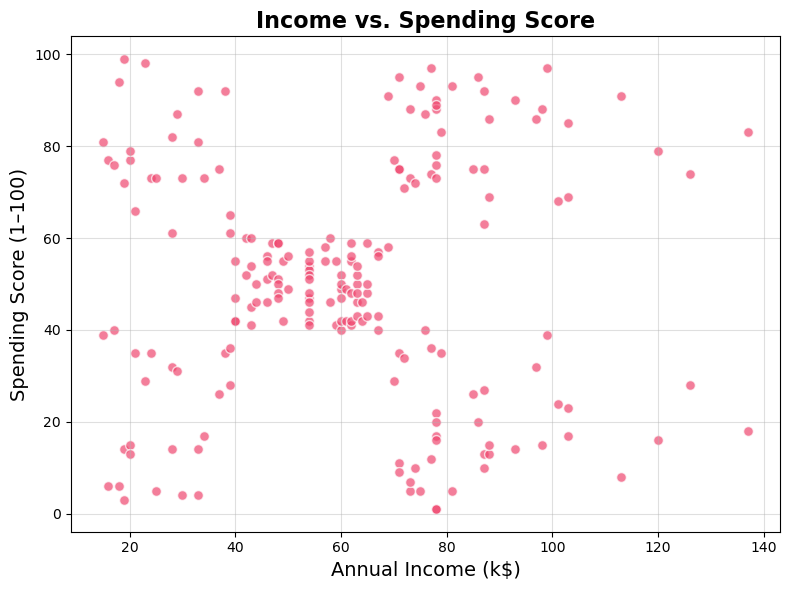

In [15]:
# 3. Exploratory Data Analysis (EDA)

# 3.1 Age distribution
plt.figure(figsize=(8,5))
plt.hist(df["Age"], bins=20,
         color="#2E86AB", edgecolor="white", alpha=0.85)
plt.title("Age Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(axis="y", alpha=0.6)
plt.tight_layout()
plt.show()

# 3.2 Spending Score distribution
plt.figure(figsize=(8,5))
plt.hist(df["Spending Score (1-100)"], bins=20,
         color="#F6C85F", edgecolor="white", alpha=0.85)
plt.title("Spending Score Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Spending Score (1–100)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(axis="y", alpha=0.6)
plt.tight_layout()
plt.show()

# 3.3 Income vs. Spending Score scatter
plt.figure(figsize=(8,6))
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"],
            s=50, c="#EF476F", alpha=0.7, edgecolors="w")
plt.title("Income vs. Spending Score", fontsize=16, fontweight="bold")
plt.xlabel("Annual Income (k$)", fontsize=14)
plt.ylabel("Spending Score (1–100)", fontsize=14)
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

Age Distribution
18–70 yaş arası geniş bir dağılım var,
25–35 ve 40–50 yaş aralıklarında pikler görülüyor,.
Spending Score Distribution
Harcama skorları 1–100 arasında yayılmış,
Orta (40–60) ve yüksek (80–100) skor bandında yoğunluk var, indirim odaklı ve premium odaklı iki ayrı segment dikkat çekiyor.
Income vs. Spending Score
Gelir arttıkça harcamada lineer bir yükseliş yok,
Dört ana bölge (yüksek gelir/yüksek harcama vs. düşük gelir/düşük harcama vs. yüksek gelir/düşük harcama vs. düşük gelir/yüksek harcama) gözlemlenebilir; bunlar kümeleme adımında netleşecek.

In [17]:
# 4. Preprocessing
df["Gender_num"] = (df["Gender"] == "Male").astype(int)
features = ["Gender_num", "Age", "Annual Income (k$)", "Spending Score (1-100)"]
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


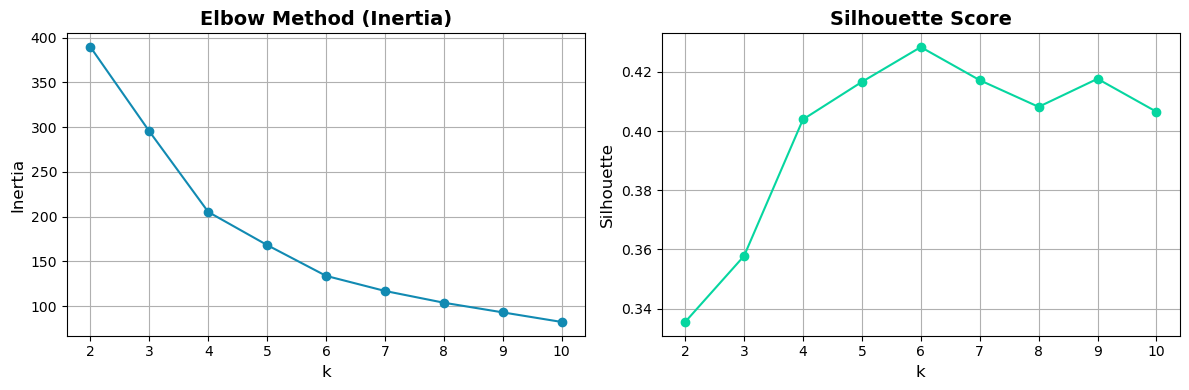

In [19]:
# 5. K-Means: Elbow & Silhouette
inertias, sil_scores = [], []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(K_range, inertias, 'o-', color="#118AB2")
ax1.set_title("Elbow Method (Inertia)", fontsize=14, fontweight="bold")
ax1.set_xlabel("k", fontsize=12); ax1.set_ylabel("Inertia", fontsize=12)
ax1.grid(True)

ax2.plot(K_range, sil_scores, 'o-', color="#06D6A0")
ax2.set_title("Silhouette Score", fontsize=14, fontweight="bold")
ax2.set_xlabel("k", fontsize=12); ax2.set_ylabel("Silhouette", fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()


In [21]:
# 6. Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=5, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)
print("Agglomerative silhouette:", round(silhouette_score(X_scaled, labels_agg), 3))


Agglomerative silhouette: 0.39


0.39, makul bir ayrım var ama hâlâ iç içe geçmiş noktalar da bulunuyor.

K-Means adımında k=5 için silhouette ≈ 0.42, k=6 için ≈ 0.43 bulmuştuk.
Demek ki K-Means, aynı küme sayısında (5) hiyerarşik kümelemeye göre biraz daha net gruplar oluşturuyor.


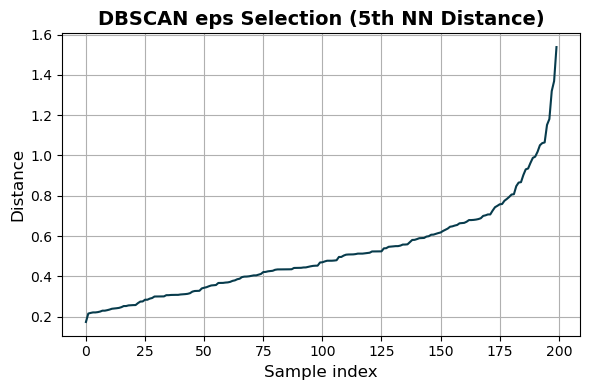

DBSCAN clusters (−1 = noise): {0, 1, -1}
DBSCAN silhouette (excluding noise): 0.273


In [23]:
# 7. DBSCAN with eps selection
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:,4])

plt.figure(figsize=(6,4))
plt.plot(distances, color="#073B4C")
plt.title("DBSCAN eps Selection (5th NN Distance)", fontsize=14, fontweight="bold")
plt.xlabel("Sample index", fontsize=12); plt.ylabel("Distance", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X_scaled)
mask = labels_db != -1
print("DBSCAN clusters (−1 = noise):", set(labels_db))
print("DBSCAN silhouette (excluding noise):",
      round(silhouette_score(X_scaled[mask], labels_db[mask]), 3))

1. k-Distance Grafiği:
Grafikte her noktanın 5. en yakın komşusuna uzaklığı küçükten büyüğe sıralanıyor.
Eğri yaklaşık 0.6–0.7 civarında aniden yükselmeye başlıyor.
Yani eps ≈ 0.6 seçmek, o yarıçap içinde yeterince sıkı kümeler bulmak için mantıklı.
2. Bulunan Küme Sayısı ve Gürültü
set(labels_db) = {0, 1, -1} → DBSCAN iki ana küme (0 ve 1) oluşturdu, geri kalan tüm noktaları ise noise (−1) olarak işaretledi.
Bu, veri setindeki çoğu noktanın ya bu iki bölgeden birine ya da “yüksek yoğunluklu değil” kategorisine düştüğü anlamına gelir.
3. Silhouette Skoru = 0.273
0.25–0.5 arası makul bir ayrım düzeyi demektir, ama 0.5’in üstü kadar “net” değil.
Yani bu iki yoğunluk temelli küme – özellikle noise’u çıkarınca biraz ayrışmış ama hala birbirlerine yakın veya iç içe geçmiş noktalar var.

DBSCAN, “yoğun bölge” olarak sadece en sıkı kümeleri yakalayıp geri kalan veriyi gürültü olarak sınıflandırdı.
Silhouette ≈ 0.27, bu küme yapısının K-Means’in ~0.42’lik skoruna göre daha zayıf bir ayrım sunduğunu gösteriyor.

Bir sonraki adımda en uygun gördüğümüz küme sayısı (k=5) ile final K-Means modelini çalıştırıp, ardından her bir kümenin temel istatistiklerini çıkardık.


In [43]:
# 8. Final K-Means (k=5) and summary
km5 = KMeans(n_clusters=5, n_init=10, random_state=42).fit(X_scaled)
df["cluster"] = km5.labels_

summary = (
    df.groupby("cluster")
      .agg({
         "Age": ["mean", "count"],
         "Annual Income (k$)": ["mean"],
         "Spending Score (1-100)": ["mean"]
      })
      .round(1)
)
summary.columns = ["_".join(col) for col in summary.columns]
summary = summary.reset_index()
print(summary)



   cluster  Age_mean  Age_count  Annual Income (k$)_mean  \
0        0      46.2         20                     26.8   
1        1      25.2         54                     41.1   
2        2      32.9         40                     86.1   
3        3      39.9         39                     86.1   
4        4      55.6         47                     54.4   

   Spending Score (1-100)_mean  
0                         18.4  
1                         62.2  
2                         81.5  
3                         19.4  
4                         48.9  


In [45]:
# 9. Add cluster names
cluster_names = {
    0: "Active Young Trendsetters",
    1: "Luxury Enthusiasts",
    2: "Thrifty Shoppers",
    3: "Mid-Market Classics",
    4: "Premium Young Elite"
}
summary["Suggested Name"] = summary["cluster"].map(cluster_names)

print("\nCluster Summary:\n", summary)



Cluster Summary:
    cluster  Age_mean  Age_count  Annual Income (k$)_mean  \
0        0      46.2         20                     26.8   
1        1      25.2         54                     41.1   
2        2      32.9         40                     86.1   
3        3      39.9         39                     86.1   
4        4      55.6         47                     54.4   

   Spending Score (1-100)_mean             Suggested Name  
0                         18.4  Active Young Trendsetters  
1                         62.2         Luxury Enthusiasts  
2                         81.5           Thrifty Shoppers  
3                         19.4        Mid-Market Classics  
4                         48.9        Premium Young Elite  


Kümeler hem yaş hem gelir hem de harcama davranışı bakımından birbirinden oldukça farklı profiller ortaya koyuyor.
Kaynak Dağılımı:
En kalabalık segment Cluster 1 (25 yaş, yüksek harcama) — genç kitlenin sadakatini artırmak uzun vadeli gelir için kritik.

In [47]:
# 10. Entropy (Gender homogeneity)
entropies = {
    c: entropy(df[df["cluster"] == c]["Gender_num"].value_counts(normalize=True), base=2)
    for c in summary["cluster"]
}
print("\nGender Entropies:", {k: round(v,2) for k, v in entropies.items()})



Gender Entropies: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}


Neden sıfır çıktığını araştırdım.

In [53]:
for c, grp in df.groupby("cluster"):
    print(f"Cluster {c}")
    print(grp["Gender"].value_counts(normalize=True), "\n")


Cluster 0
Gender
F    0.6
M    0.4
Name: proportion, dtype: float64 

Cluster 1
Gender
F    0.592593
M    0.407407
Name: proportion, dtype: float64 

Cluster 2
Gender
F    0.55
M    0.45
Name: proportion, dtype: float64 

Cluster 3
Gender
M    0.512821
F    0.487179
Name: proportion, dtype: float64 

Cluster 4
Gender
F    0.574468
M    0.425532
Name: proportion, dtype: float64 



In [55]:
from scipy.stats import entropy

entropies = {}
for c, grp in df.groupby("cluster"):
    freqs = grp["Gender"].value_counts(normalize=True).values
    entropies[c] = entropy(freqs, base=2)

print({c: round(e,2) for c,e in entropies.items()})



{0: 0.97, 1: 0.98, 2: 0.99, 3: 1.0, 4: 0.98}


Kümeleme modelimiz yaş, gelir ve harcama puanı boyutlarına dayalı gerçekten anlamlı segmentler yaratmış. Cinsiyet değişkeni görece düşük önceliğe itilmiş.

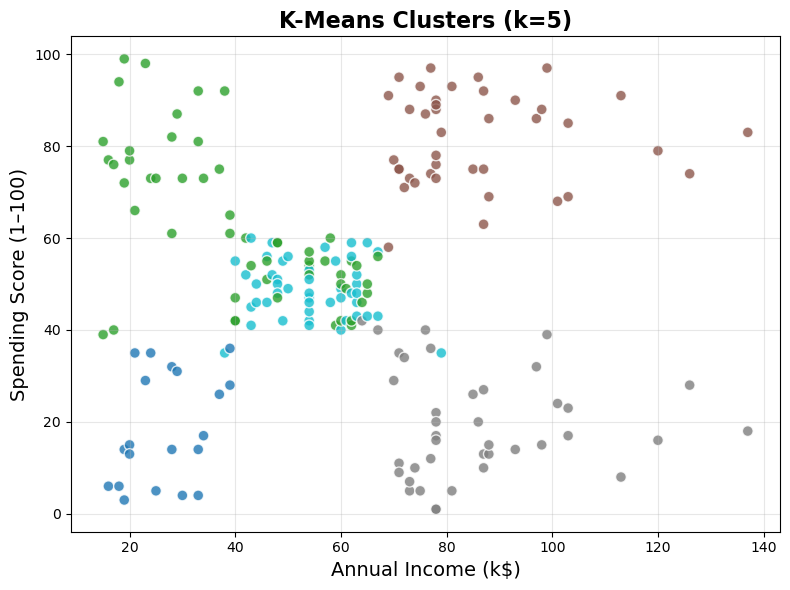

In [31]:
# 11. 2D Cluster Visualization
plt.figure(figsize=(8,6))
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"],
            c=df["cluster"], cmap="tab10", s=60, alpha=0.8, edgecolors="w")
plt.title("K-Means Clusters (k=5)", fontsize=16, fontweight="bold")
plt.xlabel("Annual Income (k$)", fontsize=14)
plt.ylabel("Spending Score (1–100)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Mavi küme (0) sol alt köşede, gelir ve harcama skorunun her ikisinin de düşük olduğu “fiyat-duyarlı” genç tüketiciler.
Yeşil küme (1) sol üst orta bölgede, nispeten daha az gelire rağmen harcamaya hevesli “trend-avcı” gençler.
Kahverengi küme (2) sağ üst köşede, hem gelir hem harcama puanı çok yüksek “premium” kullanıcılar.
Gri küme (3) sağ alt köşede, geliri yüksek ama harcamaya çekingen “tasarruflu varlıklı” grup.
Turkuaz küme (4) merkeze yakın, ne çok yüksek ne çok düşük—“orta segment, kalite-fiyat dengesine değer veren” olgun müşteri grubu.

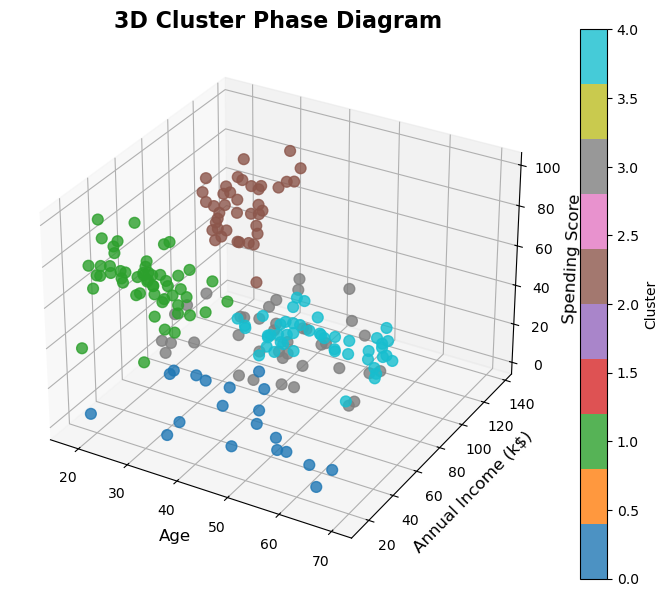

In [33]:
# 12. 3D Cluster Visualization
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df["Age"], df["Annual Income (k$)"], df["Spending Score (1-100)"],
                     c=df["cluster"], cmap="tab10", s=60, alpha=0.8)
ax.set_title("3D Cluster Phase Diagram", fontsize=16, fontweight="bold")
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Annual Income (k$)", fontsize=12)
ax.set_zlabel("Spending Score", fontsize=12)
fig.colorbar(scatter, label="Cluster")
plt.tight_layout()
plt.show()

Yaş Ayrımı:
Mavi ve turuncu küme “20–35” yaşlarında kalabalıklaşırken, gri ve turkuaz kümeler “35–60” arasında dağılmış.
Bu da “genç” vs. “olgun” tüketici stratejilerini ayrı ayrı ele almamız gerektiğini gösteriyor.
Gelir–Harcamada Çift Ayrım:
Sağ tarafta (yüksek gelir ekseni) hem çok harcayanlar (kahverengi) hem de az harcayanlar (gri) var; bunları farklı yaklaşımlarla ele almak gerek.
Sol tarafta “düşük gelir & az harcayan” (mavi) ve “orta gelir & çok harcayan” (turuncu) iki uç segment bulunuyor.